In [ ]:
%pip install nltk --upgrade

In [1]:
import pandas as pd
import requests
from pprint import pprint
import datetime

In [12]:
# define which game to scrape
appid = 24780  # simcity4
#appid = 23575701 # over watch 2

# set base name for the file
base_name = 'simcity4'
#base_name = 'overwatch2'

scrape_file = f'reviews_{base_name}.csv'
results_file = f'results_{base_name}.csv'
extended_file = f'reviews_{base_name}_extended.csv'


In [ ]:

# Open a file to write the scraped data
with open(scrape_file, "w+", encoding='utf-8') as fo:
    # Write the header for the CSV file
    print("review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review", file=fo)

    cursor = '*'  # Start with the initial cursor
    base_url = f'https://store.steampowered.com/appreviews/{appid}'

    curr_page = 0 # Initialize the current page counter
    while True:
        # Set the parameters for the API request
        params = { # https://partner.steamgames.com/doc/store/getreviews
            'json' : 1,
            'filter' : 'all', # sort by: recent, updated, all (helpfulness)
            'language' : 'english', # https://partner.steamgames.com/doc/store/localization # Onlu fetch reviews in English
            'day_range' : 9223372036854775807, # shows reviews from all time 
            'review_type' : 'all', # include all reviews (positive and negative)
            'purchase_type' : 'all', # all, non_steam_purchase, steam
            'num_per_page' : 100, # Number of reviews per page
            'cursor': cursor,  # Use the cursor returned from the last request
        }
        response = requests.get(base_url, params=params) #Make the API request
        data = response.json() # Parse the JSON response

        print(curr_page, end=" ") # Print the current page number
        curr_page += 1 # Increment the current page counter

        # Break the loop if there are no more reviews
        if 'reviews' in data and not data['reviews']:
            break
        
        page_list = data['reviews'] # Get the list of reviews from the response

        for i, page in enumerate(page_list):
            words =  page["review"].split() # Split the review text into words

            if len(words) < 30: 
                continue # Skip reviews with less than 30 words
            
            # Prepare the review text for CSV
            rev = '"' + page["review"].replace('"',"") + '"'
            author_vote = 1 if page['voted_up'] else 0 # Convert voted_up to binary
            other_votes = page['votes_up']
            weighted_vote_score = page["weighted_vote_score"] 
            votes_funny = page["votes_funny"] # Get votes_funny or default to 0
            comment_count = page["comment_count"] # Get comment_count or default to 0
            timestamp_created = datetime.datetime.fromtimestamp(page["timestamp_created"]).strftime('%Y-%m-%d %H:%M:%S') # Convert timestamp to human-readable format
            playtime_at_review = page["author"].get("playtime_at_review", 0) #Get playtime_at_review or default to 0

            # Write the extracted data to the CSV file
            print(rev, ',', author_vote, ',', other_votes, ',', weighted_vote_score, ',', votes_funny, ',', comment_count, ',', timestamp_created, ',', playtime_at_review, file=fo)

        # Update the cursor for the next API request
        cursor = data['cursor']

In [5]:
# Using the SentiWordNet lexicon instead of VADER
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd

# Download the SentiWordNet and WordNet resources
nltk.download('sentiwordnet');
nltk.download('wordnet');
nltk.download('averaged_perceptron_tagger');
nltk.download('punkt');

[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\charding\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
def get_sentiment(word, pos):
    synsets = list(swn.senti_synsets(word, pos))
    if not synsets:
        return 0, 0, 0
    synset = synsets[0]
    return synset.pos_score(), synset.neg_score(), synset.obj_score()

def sentiment_analysis_SentiWordNet(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(tokens)
    sentiment_scores = {'positive': 0, 'negative': 0, 'objective': 0 }
    word_count = 0

    for word, tag in pos_tags:
        wn_tag = get_wordnet_pos(tag)

        if wn_tag is not None:
            #print(f"{word}={wn_tag}", end=", ")
            pos_score, neg_score, obj_score = get_sentiment(word, wn_tag)
            sentiment_scores['positive'] += pos_score
            sentiment_scores['negative'] += neg_score
            sentiment_scores['objective'] += obj_score
            word_count += 1

    # Normalize the score by the number of words
    if word_count > 0:
        sentiment_scores['positive'] /= word_count
        sentiment_scores['negative'] /= word_count
        sentiment_scores['objective'] /= word_count
    print(".", end="")
    return sentiment_scores['positive'], sentiment_scores['negative'], sentiment_scores['objective'], word_count

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wn.ADJ
    elif treebank_tag.startswith('V'):
        return wn.VERB
    elif treebank_tag.startswith('N'):
        return wn.NOUN
    elif treebank_tag.startswith('R'):
        return wn.ADV
    else:
        return None

In [7]:
# Read the scraped CSV file
df = pd.read_csv(scrape_file, encoding='utf-8'  )
display(df)

,review,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,timestamp_created,playtime_at_review
0,"Alright, let's actually provide a constructive...",0,11171,0.980039,205,0,2023-08-21 13:16:50,17
1,"Alright, let's actually provide a constructive...",0,7899,0.972536,130,88,2024-01-27 00:05:18,7
2,"Alright, let's actually provide a constructive...",0,4954,0.971620,76,88,2023-12-26 23:22:02,13
3,Imagine you bought a book and its great.\r\nfe...,0,3230,0.970043,194,0,2024-02-08 13:39:54,2772
4,[i][b]What we’re hoping to do with Overwatch 2...,0,1189,0.966396,27,58,2023-08-10 14:14:46,17
...,...,...,...,...,...,...,...,...
19076,[h1]Textbook example about how to screw up you...,0,1,0.000000,0,0,2023-08-10 13:59:43,8
19077,i am addicted :( help me help me help me help ...,0,0,0.000000,0,0,2023-08-10 13:58:57,2530
19078,Piece of trash of a game with imbecile develop...,0,0,0.000000,0,0,2023-08-10 13:58:07,5
19079,I was happy to see PvE as it was the only thin...,0,0,0.000000,0,0,2023-08-10 13:57:34,8


In [ ]:
# Perform sentiment analysis on each review
results = []

reviews = df['review'].tolist()

for review in reviews:
    pos_score, neg_score, obj_score, word_count = sentiment_analysis_SentiWordNet(review)
    results.append({
        'review': review,
        'positive_score': pos_score,
        'negative_score': neg_score,
        'objective_score': obj_score,
        'word_count': word_count,
    })
    
# Convert the results to a DataFrame for better readability
results_df = pd.DataFrame(results)

# Save the results to a CSV file incase the concat does not work
results_df.to_csv(results_file, index=False)

In [ ]:
# Perform descriptive statistics, using the describe() method from pandas to compute descriptive statistics (mean, standard deviation, min, max, etc.) for the sentiment scores and word count.
#descriptive_stats = results_df.describe()
#print(descriptive_stats)

# Perform descriptive statistics on the combined DataFrame
#descriptive_stats = combined_df.describe(include='all')
#print(descriptive_stats)

# read in file so it's independent from the previous cells
results_df = pd.read_csv(results_file)

# Combine the original DataFrame with the sentiment analysis results
combined_df = pd.concat([df, results_df.drop(columns='review')], axis=1)

# Print the combined DataFrame
# print(combined_df)

# Perform descriptive statistics on the combined DataFrame
# descriptive_stats = combined_df.describe(include='all')
# print(descriptive_stats)

In [ ]:
display(combined_df)

In [ ]:
# write combined data to a new file
# this is so we can load the data back in later without having to re-compute the sentiment analysis
combined_df.to_csv(extended_file, index=False, encoding='utf-8')

In [13]:
# Load the CSV file'
df = pd.read_csv(extended_file)

# Display the first few rows of the dataset
print(df.head())

# Display basic information about the dataset
print(df.info())

# Display summary statistics of the dataset
print(df.describe(include='all'))

                                              review  author_vote  \
0  Since people don't know what the PC Gaming Wik...            1   
1  Doesn't require a constant internet connection...            1   
2  I played this game a lot when i was 12 or 13 o...            1   
3  If modded this game even though its ten years ...            1   
4  Everyone is right, it really is still the best...            1   

   other_votes  weighted_vote_score  votes_funny  comment_count  \
0          312             0.962180            4             15   
1         1235             0.957100          241             20   
2         1429             0.949670          113             39   
3          287             0.942572           12             15   
4          137             0.923562            0              0   

       timestamp_created  playtime_at_review  
0   2019-10-04 16:37:39                   79  
1   2014-11-26 16:30:17                 4303  
2   2013-07-05 05:55:15                  

In [ ]:
# Check for missing values
print(df.isnull().sum())

In [ ]:
# Display the data types of each column
print(df.dtypes)

In [26]:
# CH aggregate means of values over time (monthly)
df_agg  = df.copy() 
df_agg['timestamp_created'] = pd.to_datetime(df_agg['timestamp_created']) # make python datetime object
df_agg.set_index('timestamp_created', inplace=True) # set index to timestamp_created

# drop review column as it is not numeric
df_agg.drop(columns=['review'], inplace=True)

# resample all numeric columns to monthly
#df_agg = df_agg.resample('MS').mean() # resample all numeric columns to monthly

# resample all numeric columns to 3 month
df_agg = df_agg.resample('3MS').mean() # resample all numeric columns to 6 month

# resample all numeric columns to 6 month
#df_agg = df_agg.resample('6MS').mean() # resample all numeric columns to 6 month

df_agg.reset_index(inplace=True) # reset index to make timestamp_created a column again
df_agg['timestamp_created'] = df_agg['timestamp_created'].dt.strftime('%Y-%m') # format timestamp_created
display(df_agg)



,timestamp_created,author_vote,other_votes,weighted_vote_score,votes_funny,comment_count,playtime_at_review
0,2010-11,1.000000,0.000000,0.000000,0.000000,0.000000,4999.000000
1,2011-02,1.000000,0.000000,0.000000,0.000000,0.000000,849.500000
2,2011-05,0.900000,0.300000,0.158759,0.000000,0.500000,5569.400000
3,2011-08,1.000000,1.000000,0.263539,0.000000,0.250000,1771.000000
4,2011-11,1.000000,0.666667,0.230721,0.133333,0.266667,4551.066667
5,2012-02,0.666667,2.666667,0.510800,0.000000,0.666667,1620.333333
6,2012-05,1.000000,0.333333,0.082099,0.166667,0.083333,2828.583333
7,2012-08,0.666667,0.000000,0.000000,0.000000,0.000000,1135.333333
8,2012-11,1.000000,1.277778,0.151782,0.055556,0.444444,1676.166667
9,2013-02,1.000000,0.250000,0.126191,0.125000,0.375000,7634.250000


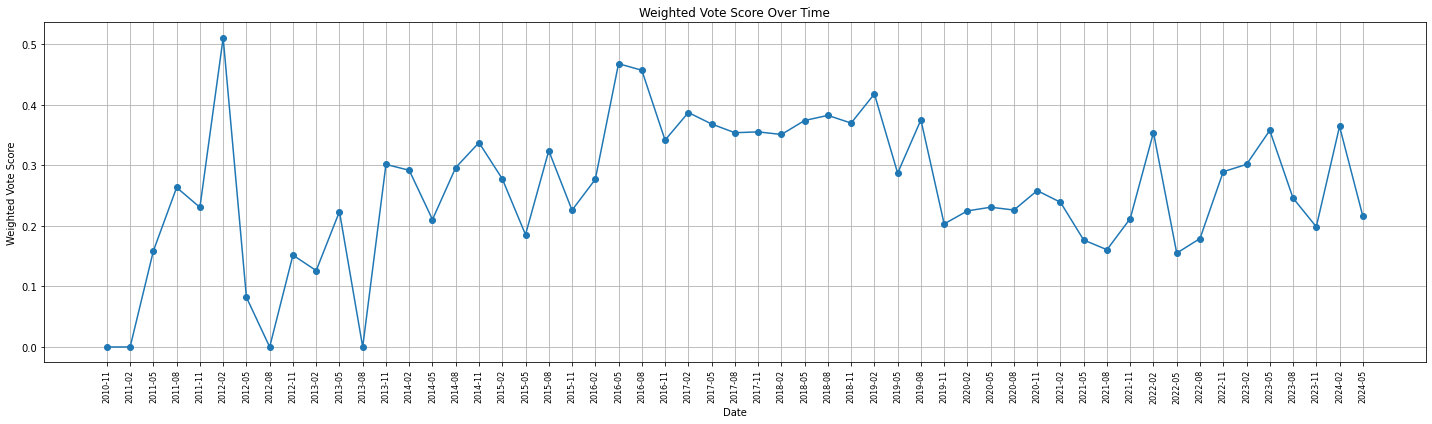

In [27]:
# plot weighted_vote_score over time
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(df_agg['timestamp_created'], df_agg['weighted_vote_score'], marker='o')
plt.title('Weighted Vote Score Over Time')
plt.xlabel('Date')
plt.ylabel('Weighted Vote Score')
plt.xticks(fontsize=8)
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()


In [ ]:
# Distribution of Numerical Variables
# Visualize the distribution of numerical variables using histograms and boxplots.
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for numerical columns
df.hist(bins=30, figsize=(15, 10))
plt.show()

# Boxplot for numerical columns
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# ideas:
# add number of nouns, verbs, adjectives, adverbs
# correlate matrix between all values
# aggregate values (author_vote) by timestamp_created into monthly value and show them as a line plot over time
# analyse data from a series of PC games e.g

# Mass Effect - 17460
# Mass Effect 2 - 24980
# Mass Effect 3 - 1238020
# Mass Effect: Andromeda - 1238000
# Mass Effect Legendary Edition - 1328670 (this is a remastered version of the original trilogy)

# Dragon Age: Origins - 17450
# Dragon Age II - 47900
# Dragon Age: Inquisition - 1222690